# Dataset

In this A/B test, users are divided into **two groups**:

* Experimental Group – Exposed to ads.
* Control Group – Shown a Public Service Announcement (PSA) or no ad at all.

The **goal** is to determine:

1. Campaign Success – Did the ads lead to a significant increase in conversions?
2. Attributable Impact – How much of the success can be directly linked to the ads?

**Data dictionary**:


* Index: Row indexuser
* id: User ID (unique)
* test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
* converted: If a person bought the product then True, else is False
* total ads: Amount of ads seen by person
* most ads day: Day that the person saw the biggest amount of ads
* most ads hour: Hour of day that the person saw the biggest amount of ads


# Data Exploration (Initial EDA and data cleaning)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 

from scipy.stats import ttest_ind, chi2_contingency, f_oneway, pearsonr, spearmanr

In [2]:
#Load dataset
df = pd.read_csv('/kaggle/input/marketing-ab-testing/marketing_AB.csv')
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [3]:
# Check for missing values and data types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB
None


In [4]:
#rename column names to standard
df.drop(['Unnamed: 0','user id'], axis=1,inplace=True)
df.columns = df.columns.str.replace(" ", "_", regex=True)

# show unique values for categorical columns
print("Unique categorical values:")
columns = df.columns.drop('total_ads')
for column in columns:
    print( column, ": ", df[column].unique())

Unique categorical values:
test_group :  ['ad' 'psa']
converted :  [False  True]
most_ads_day :  ['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday']
most_ads_hour :  [20 22 18 10 14 13 19 11 12 16 21  3 23  4  8  0  2 15  1  6 17  7  9  5]


In [5]:
print("Summary Statistics for Numerical Variables:")
print(df.describe())

Summary Statistics for Numerical Variables:
           total_ads  most_ads_hour
count  588101.000000  588101.000000
mean       24.820876      14.469061
std        43.715181       4.834634
min         1.000000       0.000000
25%         4.000000      11.000000
50%        13.000000      14.000000
75%        27.000000      18.000000
max      2065.000000      23.000000


In [6]:
# Numbers of people in test groups
print("Counts by Test Group:")
print(df['test_group'].value_counts())

# Percentages of people in test groups
print("\nCounts in percentage by Test Group:")
print(df['test_group'].value_counts(normalize=True))

# Conversion rates
print("\nConversion Rates by Test Group:")
print(df.groupby('test_group')['converted'].mean())

Counts by Test Group:
test_group
ad     564577
psa     23524
Name: count, dtype: int64

Counts in percentage by Test Group:
test_group
ad     0.96
psa    0.04
Name: proportion, dtype: float64

Conversion Rates by Test Group:
test_group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64


**Interpretation**
1. The experimental group takes **96%** of the total sample, indicating an **imbalanced group distribution**, which could impact the reliability of comparisons.
2. On average, each user in the experimental group was shown **25 ads**, with a wide range from 1 to 2,065 ads, highlighting significant variability in ad exposure.
3. The conversion rate is **2.55%** in the experimental group and **1.79%** in the control group, suggesting a potential **positive effect** of ads on conversion. However, statistical significance testing is required to confirm this effect.

   

# T-test
Compare the conversion rates between the ad group and the psa group.

In [7]:
# Subset of test groups
psa_group = df[df['test_group']=='psa']['converted']
ad_group = df[df['test_group']=='ad']['converted']

**Null Hypothesis (H0)**: There is no significant difference between conversion rate of ad group and psa group. 

**Alternative Hypothesis (H1)**: The conversion rate of the ad group is significantly greater than the conversion rate of the psa group.

In [8]:
# Perform T-Test
t_stat, p_value = ttest_ind(ad_group, psa_group, alternative='greater', equal_var=False)

print("\nT-Test Results:")
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4e}")


T-Test Results:
T-Statistic: 8.6572
P-Value: 2.5538e-18


### T-test result interpritation
* T-statistic of 8.6572 indicates a large difference between the means of the two groups
* P-value (2.5538e-18) is extremely small and well below the conventional significance level α=0.05. This provides strong evidence to reject the null hypothesis H0.
### Conclusion
The test results indicate a significant difference in conversion rates between ad group and psa group. The positive t-statistic suggests that **ad group has a higher conversion rate than psa group**.

## Bootstrap Resample
Because there is a large difference in population size between the two groups, we’ll use the Bootstrap method. This technique involves repeatedly sampling data with replacement to create new samples. By doing this, we can estimate the distribution of a statistic and make conclusions about the population.

<Axes: ylabel='Density'>

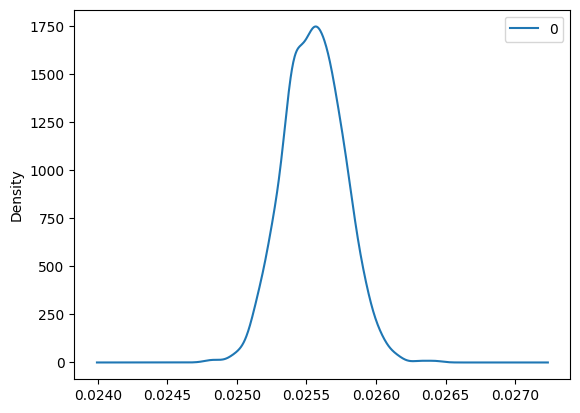

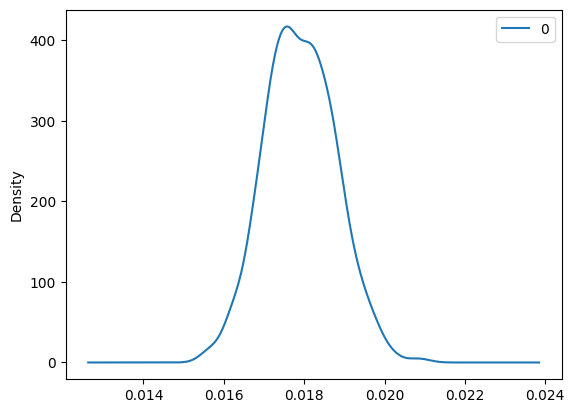

In [9]:
boot_ad=[]
boot_psa=[]

for i in range (1000):
    boot_mean=ad_group.sample(frac=1,replace=True).mean()
    boot_ad.append(boot_mean)

    boot_mean=psa_group.sample(frac=1,replace=True).mean()
    boot_psa.append(boot_mean)

boot_ad=pd.DataFrame(boot_ad)
boot_psa=pd.DataFrame(boot_psa)

boot_ad.plot(kind='density')
boot_psa.plot(kind='density')

The density plot clearly shows that the sampling distribution of the mean, derived from the bootstrap resampling process, follows an approximately normal distribution. This supports the use of statistical tests and confidence intervals that assume normality.

In [10]:
# Perform T-Test on bootstraped samples
t_stat, p_value = ttest_ind(np.array(boot_ad).flatten(), np.array(boot_psa).flatten(),alternative='greater', equal_var=False)

print("\nT-Test Results:")
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4e}")



T-Test Results:
T-Statistic: 266.6259
P-Value: 0.0000e+00


The T-test on the bootstrapped samples confirms the previous result, showing a significant difference in means between the two groups. This suggests a **positive effect** of the ads on conversion rates for the ad group.

# Chi-Squared test 
The Chi-Squared test evaluates the independence of two categorical variables. 
* Variable 1: converted (whether a user converted or not),
* Variable 2: test_group

**Null Hypothesis (H0)**: There is no association between the conversion status and the test group. 


In [11]:
# Create a contingency table
contingency_table = pd.crosstab(df['converted'], df['test_group'])

# Perform Chi-Squared Test
chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Squared Test Results - Test group:")
print(f"Chi2 Statistic: {chi2:.4f}")
print(f"P-Value: {p_chi2:.4e}")
print(f"Degrees of Freedom: {dof}")

# Let's check the correlation between day of the week and conversion
contingency_table = pd.crosstab(df[df['test_group']=='ad']['converted'], df[df['test_group']=='ad']['most_ads_day'])

# Perform Chi-Squared Test
chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Squared Test Results - Day:")
print(f"Chi2 Statistic: {chi2:.4f}")
print(f"P-Value: {p_chi2:.4e}")
print(f"Degrees of Freedom: {dof}")


Chi-Squared Test Results - Test group:
Chi2 Statistic: 54.0058
P-Value: 1.9990e-13
Degrees of Freedom: 1

Chi-Squared Test Results - Day:
Chi2 Statistic: 412.7943
P-Value: 4.9595e-86
Degrees of Freedom: 6


### Chi-Squared test interpritation

**Test group VS Conversion**
The Chi2 statistic of 54.0058 indicates a **large difference** between the observed and expected frequencies in the categorical data. A high Chi-squared value suggests a **strong association** between the variables being tested.

P-value of 1.9990e-13 is extremely small, well below the commonly used significance threshold of 0.05. This indicates that the result is **statistically significant**, and the likelihood that the observed difference occurred by random chance is extremely low.

The degrees of freedom (df = 1) indicate there are two categories in both variables.

**Day of the week VS Conversion**

There is an **extremely strong association** between the day of the week and conversion rate. The high Chi2 statistic and extremely small P-value indicate that the observed differences are highly unlikely to be due to random chance.

Further investigation is needed to determine whether the number of shown ads differs across the days of the week, as this could be a contributing factor to the variation in conversion rates.

# Pearson correlation
Measure the relationship between the total_ads and conversion_rate, most_ads_day and conversion_rate, most_ads_hour and conversion_rate.



In [12]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['most_ads_day_numeric'] = encoder.fit_transform(df['most_ads_day'])

# Pearson correlation between total_ads and converted
pearson_corr, pearson_p_value = pearsonr(df['total_ads'], df['converted'])
print(f"Pearson Correlation: {pearson_corr:.4f}, p-value: {pearson_p_value:.4e}")

Pearson Correlation: 0.2174, p-value: 0.0000e+00


### Total ads - Conversion
A Pearson correlation of 0.2174 indicates a **weak positive relationship** between the two variables. As one variable increases, the other tends to increase as well, but the relationship is not very strong.

The p-value of 0.0000 is extremely small, indicating that this correlation is **statistically significant**. We can reject the null hypothesis that there is no correlation between the variables.

# Visualization

## Conversion Rates by Test Group¶

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


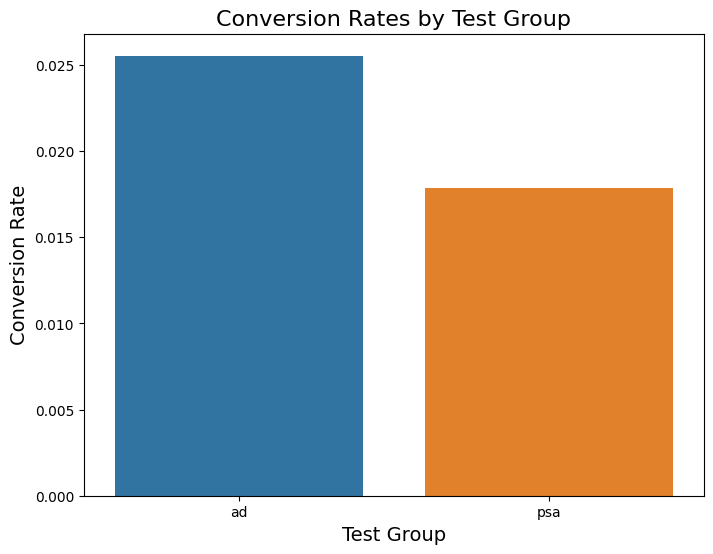

In [13]:
ad_df =df[df['test_group']=='ad']
plt.figure(figsize=(8, 6))
sns.barplot(x=['ad','psa'], y=[ad_group.mean(), psa_group.mean()])
plt.title('Conversion Rates by Test Group', fontsize=16)
plt.xlabel('Test Group', fontsize=14)
plt.ylabel('Conversion Rate', fontsize=14)
plt.show()

## Conversion Rate by Day and Test Group

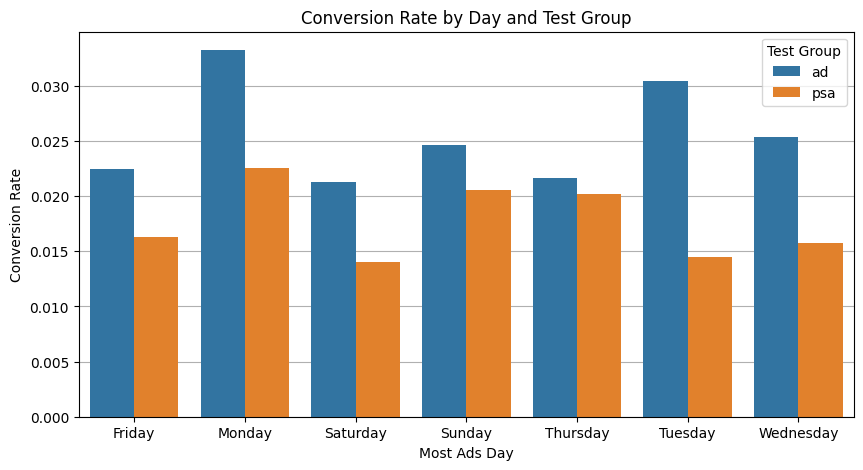

In [14]:
conversionRateByDay = df.groupby(['most_ads_day', 'test_group'])['converted'].mean()

df_plot = conversionRateByDay.reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='most_ads_day', y='converted', hue='test_group',data=df_plot)
plt.xlabel('Most Ads Day')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Day and Test Group')
plt.legend(title='Test Group')
plt.grid(which='major',axis='y')
plt.gca().set_axisbelow(True) 

plt.show()

## Conversion Rate by Day of Week and Hour of Day

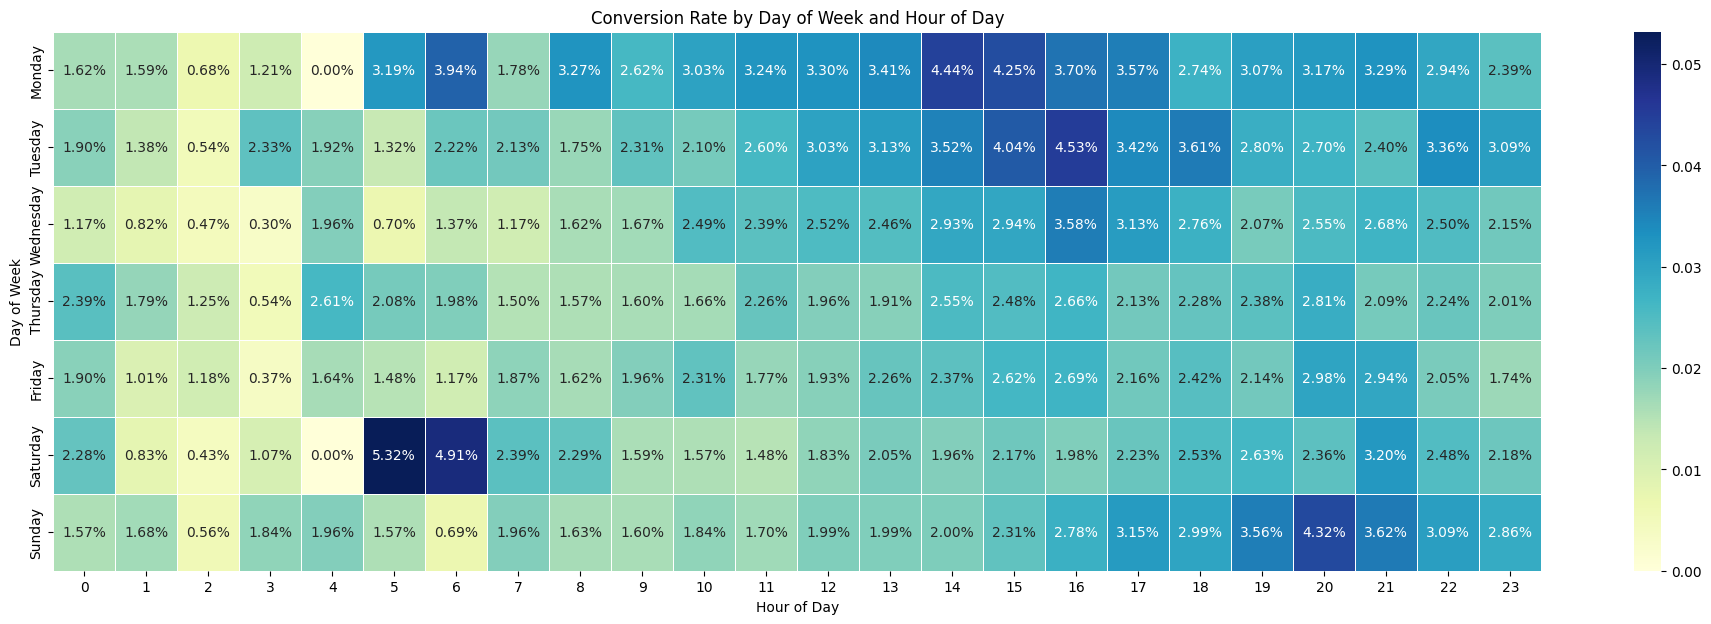

In [15]:
# Group by day of the week and hour, calculating conversion rate
heatmap_data = df.groupby(['most_ads_day', 'most_ads_hour'])['converted'].mean().reset_index()

# Pivot the data for heatmap format
heatmap_pivot = heatmap_data.pivot(index='most_ads_day', columns='most_ads_hour', values='converted')

# Sort the days of the week correctly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_pivot = heatmap_pivot.reindex(day_order)

# Plot heatmap
plt.figure(figsize=(24, 7))
sns.heatmap(heatmap_pivot, cmap="YlGnBu", annot=True, fmt=".2%", linewidths=0.5)

# Labels and title
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.title("Conversion Rate by Day of Week and Hour of Day")

plt.show()

# Conclusions
The results indicate that ads have a **significant positive** effect on the conversion rate. The experimental group (ad) exhibited a higher conversion rate compared to the control group (psa), with statistical tests confirming that this difference is statistically significant.

Additionally, there is a **strong correlation** between the day of the week and conversion rate, suggesting that conversions vary significantly across different days.
Furthermore, conversion rates tend to be higher in the afternoon, highlighting a potential time-based pattern in user behavior.